# Data simulation

Using the [Dynamic Generalised Models](https://github.com/ruivieira/python-ssm) library

In [1]:
from pssm.dglm import NormalDLM
from pssm.structure import UnivariateStructure
import numpy as np

np.random.seed(23)

Each entry in the dataset will correspond to a single day.

Create a (univariate) DGLM with a period of 7 days (weekly) using a simple seasonal component with one harmonic.

This corresponds to simulating daily hits on a web server with a weekly pattern.

We will keep the underlying mean with a small variance to make it a (relatively) stable time-series.

In [2]:
weekly_period = 7

structure = UnivariateStructure.locally_constant(0.4) + \
            UnivariateStructure.cyclic_fourier(period=weekly_period, harmonics=1, W=np.identity(2)*4.0)

In [3]:
ndlm = NormalDLM(structure=structure, V=2.5)

In [4]:
structure.G

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.6234898 ,  0.78183148],
       [ 0.        , -0.78183148,  0.6234898 ]])

Simulate a dataset with 730 days (~2 years).

Mean server hits prior of `200`.

In [5]:
m0 = np.array([100, 0, 0])
C0 = np.identity(3)*0.1
state0 = np.random.multivariate_normal(m0, C0)

states = [state0]

N = 365

for t in range(1, N):
    states.append(ndlm.state(states[t-1]))
    
obs = [None]
for t in range(1, N):
    obs.append(ndlm.observation(states[t]))

Data for the whole series:

Text(0, 0.5, 'Hits')

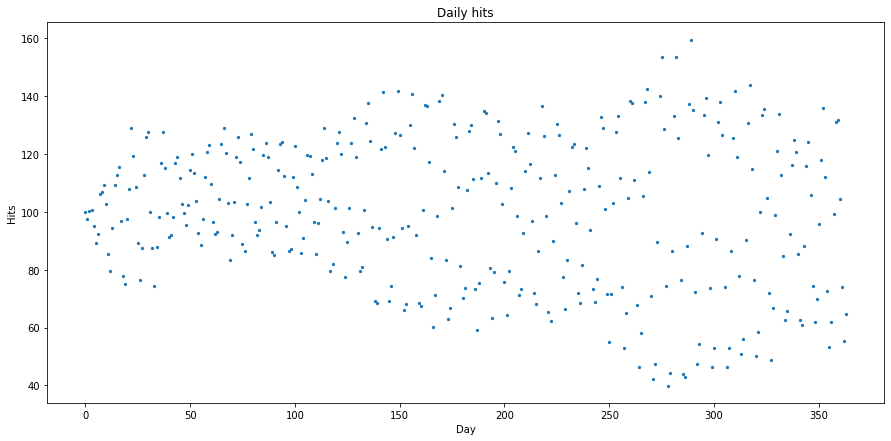

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.scatter(range(N-1), obs[1:], s=5)
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")

Data for the first two "months" (~60 days).

Text(0, 0.5, 'Hits')

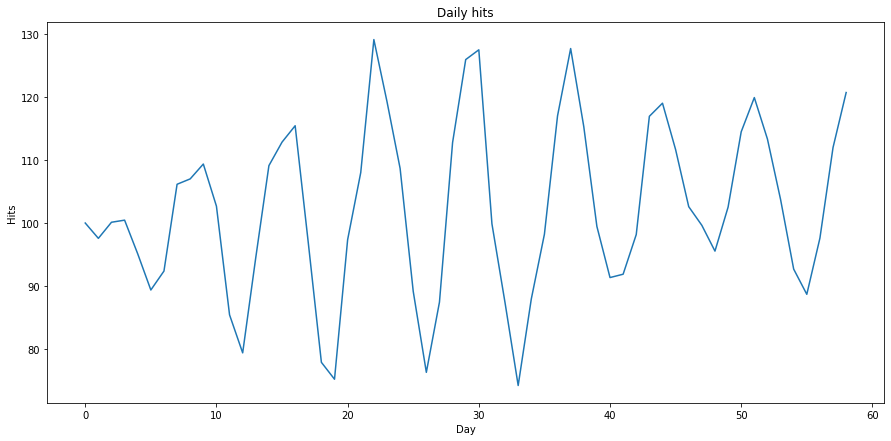

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(obs[1:60])
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")

Add random anomalies by increasing the state randomly.

We set the anomaly times manually just for testing, randomise later.

In [8]:
def generate_anomalous_data(structure, 
                            n_obs,
                            m0,
                            C0,
                            V,
                            anomaly_times,
                            ratio):
    ndlm = NormalDLM(structure=structure, V=V)
    state0 = np.random.multivariate_normal(m0, C0)

    states = [state0]

    for t in range(1, n_obs):
        states.append(ndlm.state(states[t-1]))
    
    for t in anomaly_times:
        states[t] = states[t] * ratio
    
    obs = [None]
    for t in range(1, N):
        obs.append(ndlm.observation(states[t]))

    return obs

Generate a new dataset with anomalies at day `27`, `53`, `270` (just for testing).

In [9]:
obs = generate_anomalous_data(structure, N, m0, C0, 5.0, [27, 53, 270], 3.0)

We will need to use observations as arrays often, so do it now.

In [10]:
Y = np.array(obs[1:]).reshape(-1,1)

Convert to integer observations

In [11]:
# Y = Y.astype(int)
Y[:10]

array([[108.38085263],
       [100.42066889],
       [103.11316303],
       [106.81553177],
       [102.68941114],
       [115.47385736],
       [ 92.91104344],
       [ 97.77877512],
       [ 93.31030738],
       [ 96.07052266]])

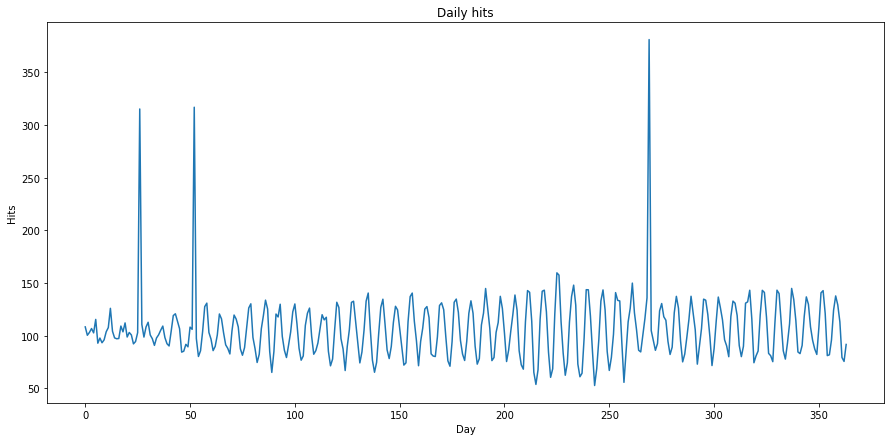

In [12]:
plt.figure(figsize=(15, 7))
plt.plot(Y)
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.show()

Data for the first 60 days:

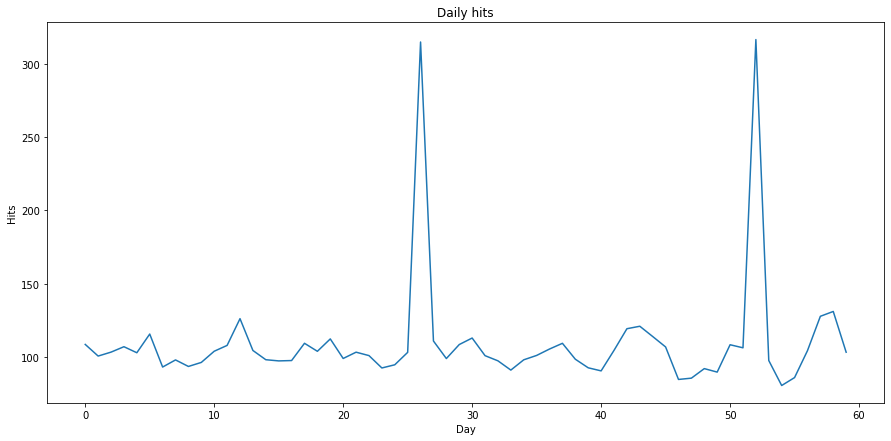

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(Y[:60])
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.show()

Convert into dataframe (just for plotting, really...)

In [14]:
import pandas as pd

In [15]:
df = pd.DataFrame(Y, columns=["y"])
df.head()

,y
0,108.380853
1,100.420669
2,103.113163
3,106.815532
4,102.689411


# Outlier detection

## (Local) outlier factor

Train the local outlier detector with the whole dataset[^1].

[^1]: Again, just for training purposes.

In [16]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(contamination='auto', novelty=True)
clf.fit(Y)

LocalOutlierFactor(novelty=True)

Store the detected anomalies (if any) on the dataframe.

In [17]:
anomalies = clf.predict(Y)

In [18]:
df['anomaly'] = anomalies

Plot the data for the first 60 days, along with the anomalies (red).

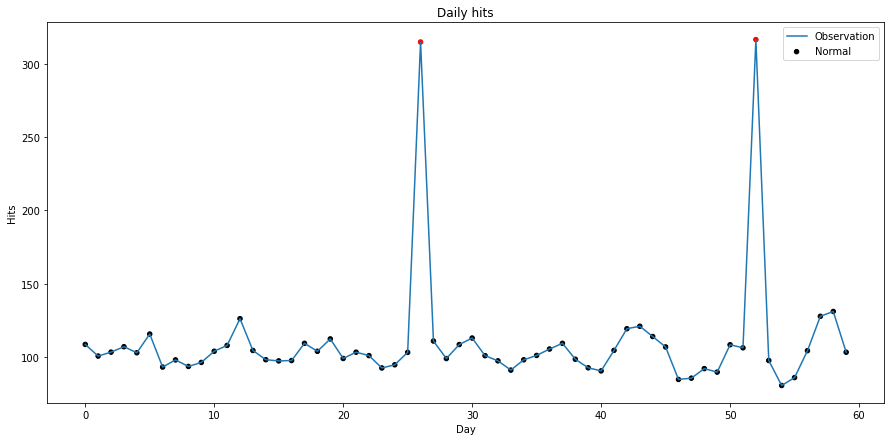

In [19]:
plt.figure(figsize=(15, 7))
d = df.head(60)
plt.plot(Y[:60])
plt.scatter(x=range(60), y=d['y'], c=list(d['anomaly'].map({1: 'black', -1: 'red'})), s=20)
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.legend(['Observation', 'Normal'])

## n-$\sigma$

Using 3-$\sigma$. Calculate standard deviation:

In [20]:
bounds = [Y.mean() + 3*Y.std(), Y.mean() - 3*Y.std()]
bounds

[197.99226123458848, 14.91153798416434]

Find outliers according to our criteria.

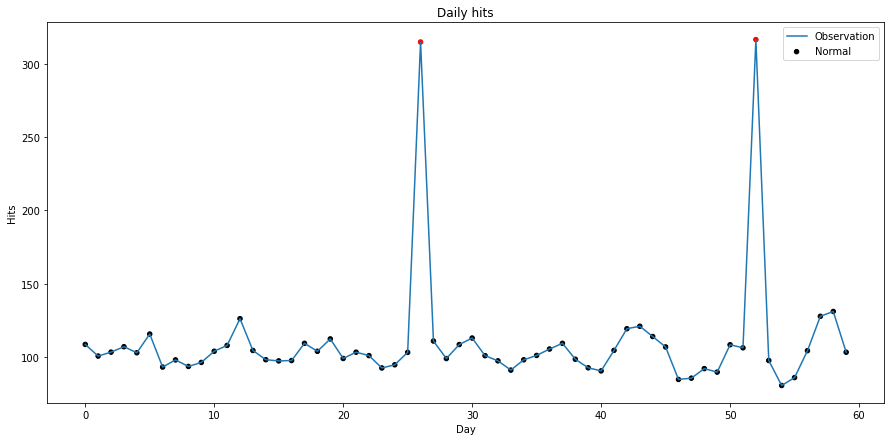

In [21]:
plt.figure(figsize=(15, 7))
colours = d['y'].transform(lambda x: 'black' if x > bounds[1] and x < bounds[0] else 'red')
plt.plot(Y[:60])
plt.scatter(x=range(60), y=d['y'], c=list(colours), s=20)
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.legend(['Observation', 'Normal'])

Remove anomalies from the dataset for training purposes. Replace them with the mean historical value.

In [22]:
y_mean = Y.mean()
df['y_train'] = df['y'].apply(lambda x: x if x > bounds[1] and x < bounds[0] else y_mean)

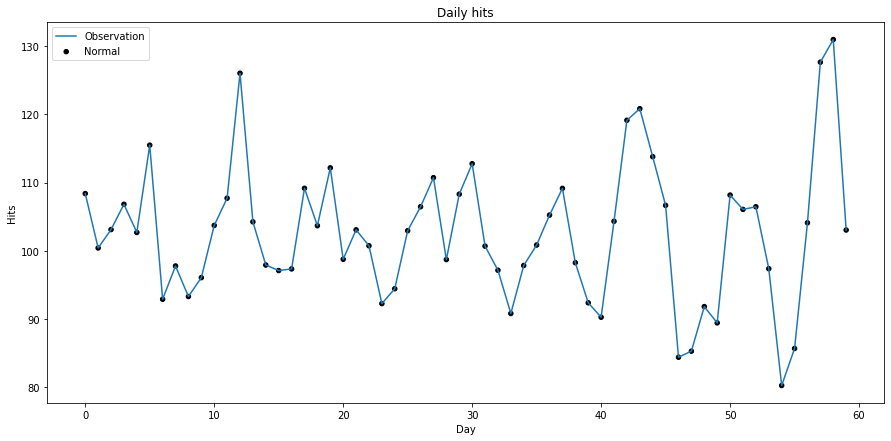

In [23]:
plt.figure(figsize=(15, 7))
colours = df.head(60)['y_train'].transform(lambda x: 'black' if x > bounds[1] and x < bounds[0] else 'red')
plt.plot(df['y_train'][:60])
plt.scatter(x=range(60), y=df['y_train'][:60], c=list(colours), s=20)
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.legend(['Observation', 'Normal'])

# XGBoost

Forecast the data using XBoost.

Normalise data for LSTM.

In [24]:
df['day'] = list(range(364))
df['day_scaled'] = df['day'] / 364.0
df.head()

,y,anomaly,y_train,day,day_scaled
0,108.380853,1,108.380853,0,0.000000
1,100.420669,1,100.420669,1,0.002747
2,103.113163,1,103.113163,2,0.005495
3,106.815532,1,106.815532,3,0.008242
4,102.689411,1,102.689411,4,0.010989


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(Y)
df['y_train_scaled'] = scaler.fit_transform(df['y_train'].to_numpy().reshape(-1, 1))
df['y_scaled'] = scaler.fit_transform(df['y'].to_numpy().reshape(-1, 1))
df

,y,anomaly,y_train,day,day_scaled,y_train_scaled,y_scaled
0,108.380853,1,108.380853,0,0.000000,0.520286,0.169450
1,100.420669,1,100.420669,1,0.002747,0.445867,0.145212
2,103.113163,1,103.113163,2,0.005495,0.471039,0.153410
3,106.815532,1,106.815532,3,0.008242,0.505652,0.164684
4,102.689411,1,102.689411,4,0.010989,0.467077,0.152120
...,...,...,...,...,...,...,...
359,129.261778,1,129.261778,359,0.986264,0.715502,0.233029
360,113.189830,1,113.189830,360,0.989011,0.565246,0.184092
361,79.343756,1,79.343756,361,0.991758,0.248818,0.081037
362,75.594282,1,75.594282,362,0.994505,0.213764,0.069620


In [26]:
from xgboost import XGBRegressor 

model = XGBRegressor()
model.fit(df.day, df.y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Timepoint `t=268` (non-anomalous in our data)

In [27]:
t=268
df['y'][t]

136.02720740936732

Should be non-anomalous (`p=1`)

In [28]:
clf.predict(np.array(df['y'][t]).reshape(-1, 1))

array([1])

Predicted observation:

In [29]:
prediction = model.predict(np.array(df['y'][t-1]).reshape(-1, 1))
print(f"Observed value = {round(df['y'][t-1])} hits, predicted = {round(prediction[0])} hits")

Observed value = 116 hits, predicted = 85 hits


Now, timepoint `t=269` (**anomalous** in our data)

In [30]:
t=269
df['y'][t]

381.1543038968949

Should be **anomalous** (`p=-1`)

In [31]:
clf.predict(np.array(df['y'][t]).reshape(-1, 1))

array([-1])

Predicted observation:

In [32]:
prediction = model.predict(np.array(df['y'][t]).reshape(-1, 1))
print(f"Observed value = {round(df['y'][t])} hits, predicted = {round(prediction[0])} hits")

Observed value = 381 hits, predicted = 91 hits


## Constant $\sigma$ detection

The $\sigma$ was calculated as

In [33]:
sigma = df['y'].std()
sigma

30.55545451969315

Performing anomaly detection online with the current sigma.
We calculate a residual, $r$ as

$$
r = (y - \hat{y})
$$

First get the predictions.

In [34]:
prediction = model.predict(df['day'])

Calculate $r$.

In [35]:
r = (df['y'] - prediction)

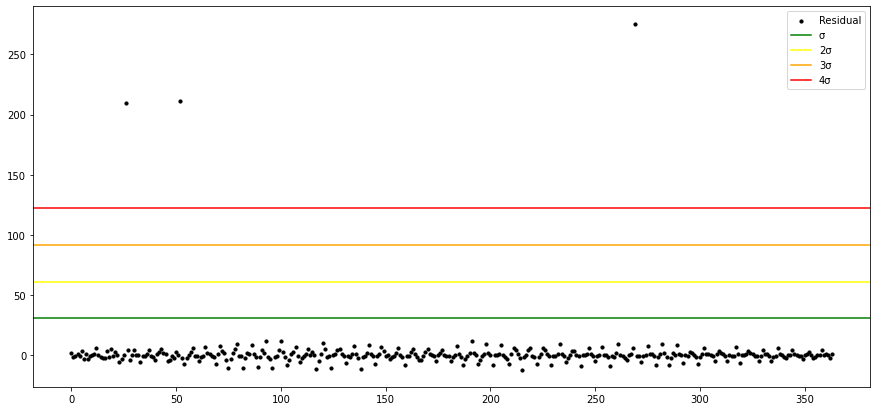

In [36]:
plt.figure(figsize=(15, 7))
plt.scatter(df['day'], r, c='black', s=10)
plt.axhline(y=sigma, color='green', linestyle='-')
plt.axhline(y=2*sigma, color='yellow', linestyle='-')
plt.axhline(y=3*sigma, color='orange', linestyle='-')
plt.axhline(y=4*sigma, color='red', linestyle='-')
plt.legend(['Residual', 'σ', '2σ', '3σ', '4σ' ])
plt.show()

## New data dataset

In [37]:
new_obs = generate_anomalous_data(structure, N, m0, C0, 5.0, [100, 200, 300], 3.0)
new_df = pd.DataFrame(new_obs[1:], columns=["y"])
new_df['day'] = list(range(364))
new_df.head()

,y,day
0,93.190865,0
1,99.438026,1
2,108.694434,2
3,103.267001,3
4,92.428484,4


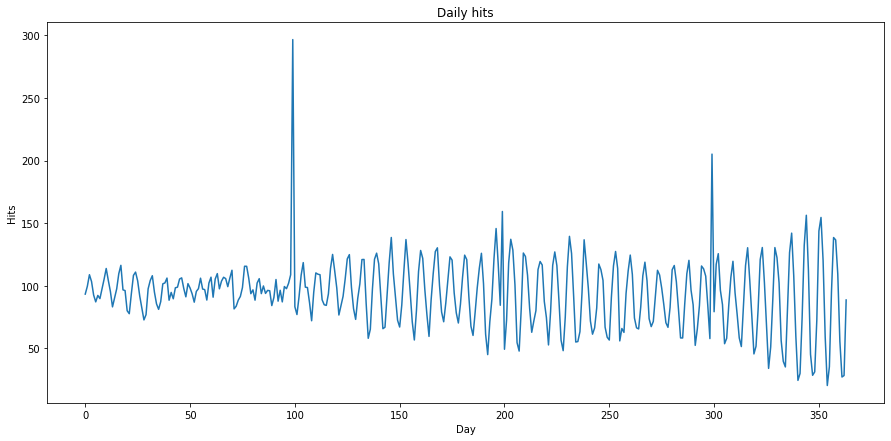

In [38]:
plt.figure(figsize=(15, 7))
plt.plot(new_df['y'])
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.show()

In [39]:
prediction = model.predict(new_df['day'])
r = (new_df['y'] - prediction)

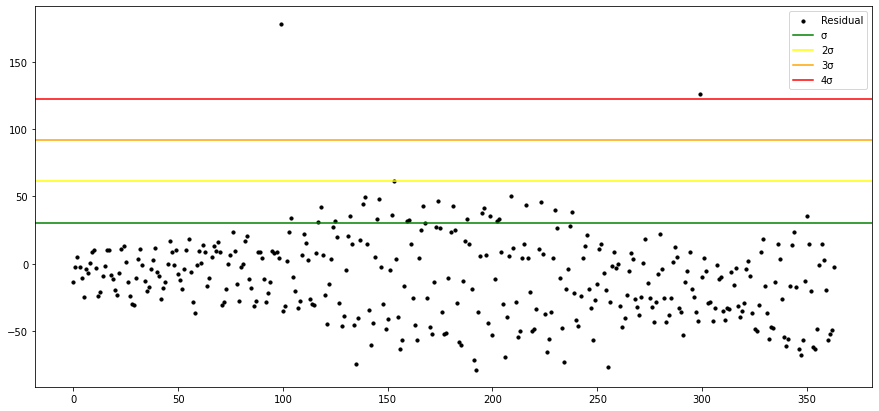

In [40]:
plt.figure(figsize=(15, 7))
plt.scatter(new_df['day'], r, c='black', s=10)
plt.axhline(y=sigma, color='green', linestyle='-')
plt.axhline(y=2*sigma, color='yellow', linestyle='-')
plt.axhline(y=3*sigma, color='orange', linestyle='-')
plt.axhline(y=4*sigma, color='red', linestyle='-')
plt.legend(['Residual', 'σ', '2σ', '3σ', '4σ' ])
plt.show()

## Save model

In [41]:
import joblib
import os

OUTPUT_DIR = "../model"

model.save_model(os.path.join(OUTPUT_DIR, "model.bst"))